#CNN + MLP

####Importing Modules

In [ ]:
import os
import shutil
import librosa
import numpy as np
import pandas as pd
import librosa.display
import IPython.display as ipd
from kagglehub import dataset_download
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")


####Load Dataset

In [ ]:
path = dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to dataset files:", path)

speech_output_path = "/content/ravdess_speech"
os.makedirs(speech_output_path, exist_ok=True)

Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1


In [ ]:
def filter_speech_files(path, output_path):
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith(".wav"):
                parts = file.split("-")

                if parts[0] == "03" and parts[1] == "01":
                    src_path = os.path.join(root, file)
                    dest_path = os.path.join(output_path, file)
                    shutil.copy(src_path, dest_path)
    print(f"Speech audio files saved to: {output_path}")

filter_speech_files(path, speech_output_path)

Speech audio files saved to: /content/ravdess_speech


In [ ]:
folder_path = "/content/ravdess_speech/"
files = os.listdir(folder_path)
print(files)

['03-01-03-01-01-02-09.wav', '03-01-07-02-02-02-10.wav', '03-01-08-02-02-01-09.wav', '03-01-03-01-02-01-12.wav', '03-01-04-01-01-01-08.wav', '03-01-03-02-01-01-16.wav', '03-01-06-02-02-01-10.wav', '03-01-04-01-01-01-21.wav', '03-01-06-01-02-02-20.wav', '03-01-08-02-01-01-21.wav', '03-01-02-01-01-01-09.wav', '03-01-04-01-02-02-17.wav', '03-01-08-01-02-01-24.wav', '03-01-07-01-02-02-18.wav', '03-01-08-01-02-01-09.wav', '03-01-07-02-01-01-03.wav', '03-01-04-02-01-02-04.wav', '03-01-05-02-02-01-24.wav', '03-01-04-01-02-02-12.wav', '03-01-07-01-01-01-17.wav', '03-01-04-02-01-01-03.wav', '03-01-03-01-02-01-11.wav', '03-01-05-02-02-02-21.wav', '03-01-06-02-02-01-05.wav', '03-01-02-02-01-01-16.wav', '03-01-01-01-01-02-22.wav', '03-01-06-01-01-01-18.wav', '03-01-06-01-01-01-20.wav', '03-01-03-01-01-01-05.wav', '03-01-04-01-02-02-20.wav', '03-01-05-01-01-02-01.wav', '03-01-08-02-01-02-06.wav', '03-01-06-01-01-02-21.wav', '03-01-05-02-01-01-11.wav', '03-01-05-01-01-01-12.wav', '03-01-07-01-01-01-

####Audio Playback and Waveform Visualization

Playing Audio: Neutral


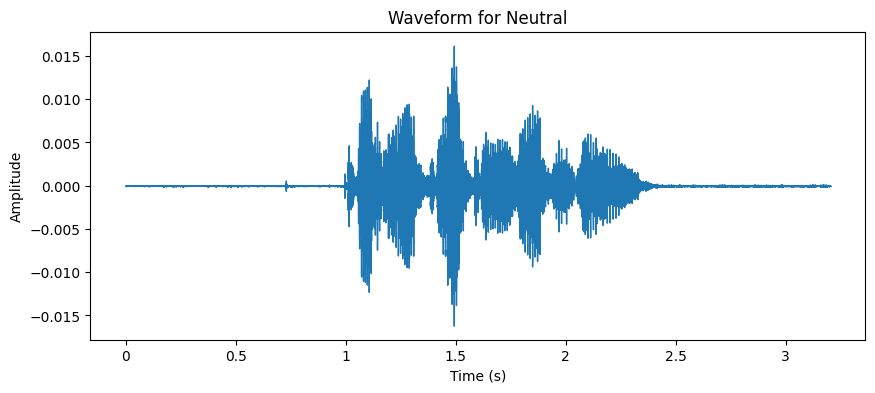

Playing Audio: Calm


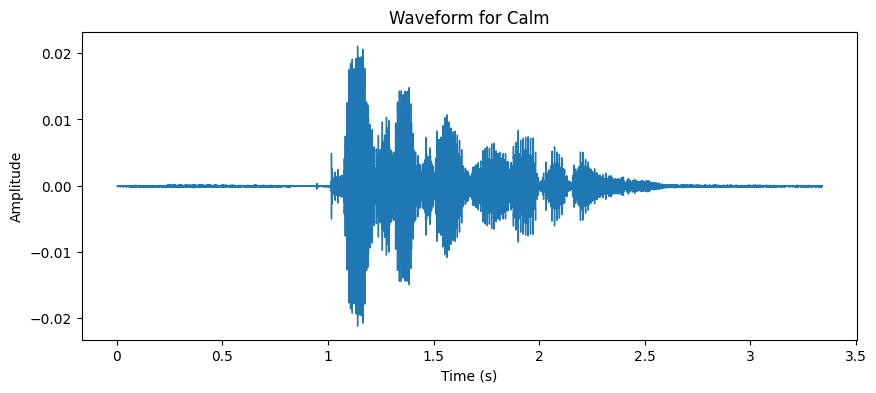

Playing Audio: Happy


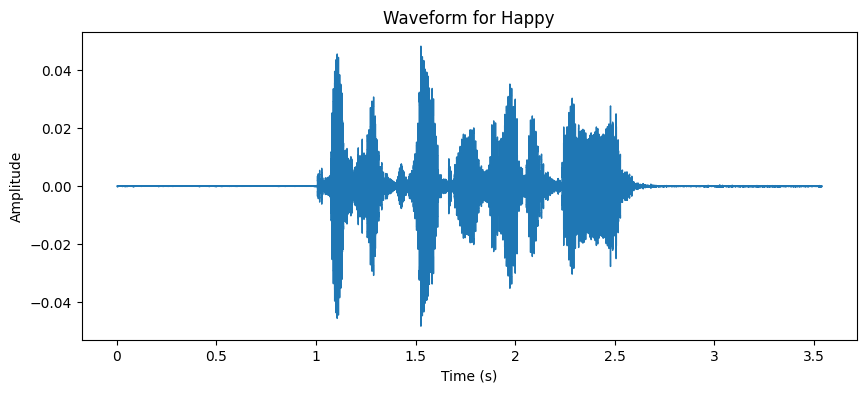

Playing Audio: Sad


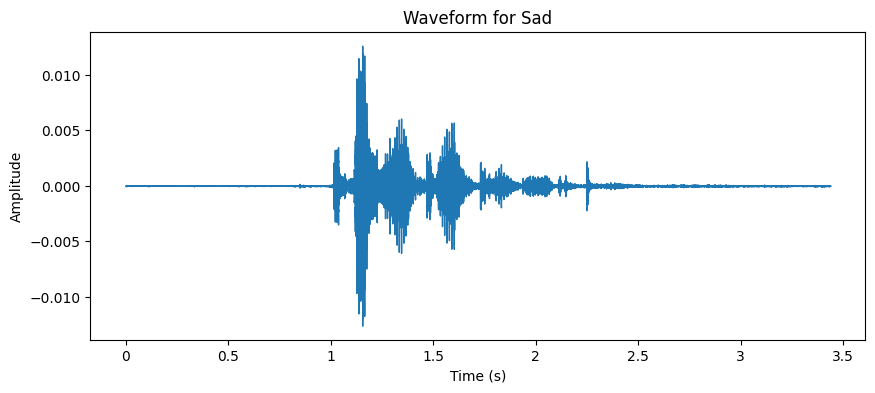

Playing Audio: Angry


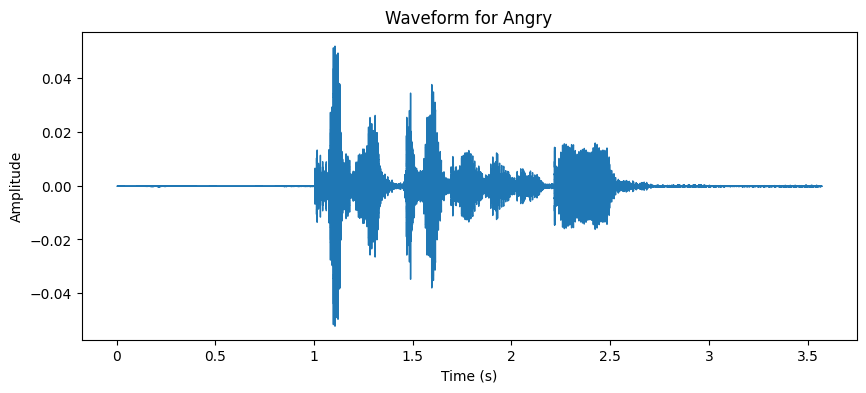

Playing Audio: Fearful


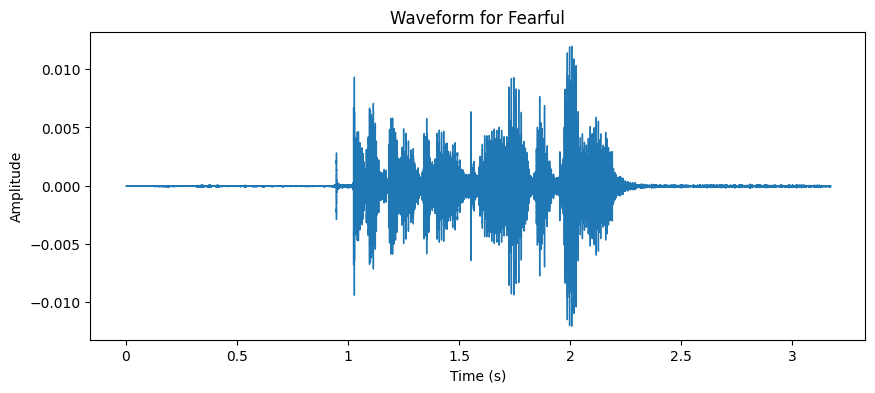

In [ ]:
base_path = "/content/ravdess_speech/"
emotion_labels = {
    "01": "Neutral",
    "02": "Calm",
    "03": "Happy",
    "04": "Sad",
    "05": "Angry",
    "06": "Fearful"
}

for emo_code in ["01", "02", "03", "04", "05", "06"]:
    file_name = f"{base_path}03-01-{emo_code}-01-01-02-09.wav"

    try:
        data, sample_rate = librosa.load(file_name)

        # Display Audio
        print(f"Playing Audio: {emotion_labels[emo_code]}")
        display(ipd.Audio(file_name))

        # Plot Waveform
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(data, sr=sample_rate)
        plt.title(f"Waveform for {emotion_labels[emo_code]}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.show()

    except Exception as e:
        print(f"Error loading {file_name}: {e}")


####Feature Extraction

In [ ]:
def compute_snr(y):
    signal_power = np.mean(y ** 2)
    noise_power = np.var(y)
    return 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.nan

In [ ]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    features = {
        "snr": compute_snr(y),
        "mfcc_mean": np.mean(mfccs, axis=1).tolist(),
        "chroma_stft": np.mean(librosa.feature.chroma_stft(y=y, sr=sr)),
        "mel_mean": np.mean(librosa.feature.melspectrogram(y=y, sr=sr)),
        "spectral_contrast": np.mean(librosa.feature.spectral_contrast(y=y, sr=sr)),
        "tonnetz": np.mean(librosa.feature.tonnetz(y=y, sr=sr)) if y.shape[0] > sr else np.nan,
        "spectral_centroid": np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
        "spectral_rolloff": np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),
        "spectral_bandwidth": np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
        "tempo": librosa.beat.tempo(y=y, sr=sr)[0],
        "rms": np.mean(librosa.feature.rms(y=y)),
        "zero_crossing_rate": np.mean(librosa.feature.zero_crossing_rate(y)),
    }

    for i in range(14):
        features[f"mfcc_{i+1}"] = np.mean(mfccs[i, :])

    return features

In [ ]:
def process_dataset(directory):
    data = []
    for file in os.listdir(directory):
        if file.endswith(".wav"):
            parts = file.split("-")
            emotion = int(parts[2])
            intensity = int(parts[3])
            statement = int(parts[4])
            repetition = int(parts[5])
            actor = int(parts[6].split(".")[0])
            gender = "Female" if actor % 2 == 0 else "Male"

            file_path = os.path.join(directory, file)
            features = extract_features(file_path)

            data.append({
                "file": file,
                "emotion": emotion,
                "intensity": intensity,
                "statement": statement,
                "repetition": repetition,
                "actor": actor,
                "gender": gender,
                **features
            })
    return pd.DataFrame(data)

In [ ]:
df = process_dataset(speech_output_path)

<ipython-input-30-705932618f16>:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  "tempo": librosa.beat.tempo(y=y, sr=sr)[0],


In [ ]:
df.to_csv("ravdess_features.csv", index=False)
print("Feature extraction complete. Data saved to ravdess_features.csv")

Feature extraction complete. Data saved to ravdess_features.csv


In [ ]:
display(df)

,file,emotion,intensity,statement,repetition,actor,gender,snr,mfcc_mean,chroma_stft,...,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14
0,03-01-03-01-01-02-09.wav,3,1,1,2,9,Male,6.730347e-06,"[-706.4300537109375, 95.19895935058594, 4.8495...",0.611301,...,11.469189,20.628059,-0.071016,-1.098409,-1.411684,-3.376450,-0.645813,3.638185,-1.383431,-0.284800
1,03-01-07-02-02-02-10.wav,7,2,2,2,10,Female,0.000000e+00,"[-476.0867004394531, 70.18885040283203, -10.70...",0.369353,...,-10.387790,4.679593,-19.215637,-1.456996,-16.618340,-13.975317,-6.438006,0.483184,-8.370224,-10.930006
2,03-01-08-02-02-01-09.wav,8,2,2,1,9,Male,1.035439e-06,"[-751.964599609375, 76.01713562011719, 10.1744...",0.528253,...,8.567366,16.729588,-0.157966,4.658631,-2.602558,0.269521,-0.405713,-2.892875,-3.087559,-0.473730
3,03-01-03-01-02-01-12.wav,3,1,2,1,12,Female,0.000000e+00,"[-621.8660888671875, 65.24585723876953, -11.99...",0.479008,...,-0.519485,7.619534,-13.272074,-0.297851,-10.450953,-12.336401,-5.172411,-3.245183,-8.796328,-0.610236
4,03-01-04-01-01-01-08.wav,4,1,1,1,8,Female,9.836657e-06,"[-752.6741943359375, 71.02371215820312, 17.396...",0.566075,...,9.684851,20.472408,-1.417557,12.607273,-4.493764,1.043121,0.071770,-1.172807,1.800034,-4.045017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,03-01-06-02-02-01-14.wav,6,2,2,1,14,Female,0.000000e+00,"[-521.8727416992188, 33.33415222167969, -26.97...",0.401203,...,-10.838760,-5.483819,-19.880278,-2.062749,-13.693341,-14.032293,-1.549396,-6.734634,-13.192415,-3.512537
1436,03-01-07-01-02-01-04.wav,7,1,2,1,4,Female,-7.765792e-07,"[-607.0526123046875, 47.369075775146484, -5.25...",0.452226,...,-6.792320,3.111269,-12.387634,-1.556534,-10.128782,-9.280766,-5.295249,-3.558451,-4.960642,-4.803607
1437,03-01-06-02-02-01-07.wav,6,2,2,1,7,Male,0.000000e+00,"[-462.95330810546875, 45.73112869262695, -22.4...",0.456878,...,-8.094124,9.149704,-21.062580,-8.943297,-11.324056,-12.091948,-7.007240,-6.466037,-7.653590,-4.470612
1438,03-01-05-01-01-01-19.wav,5,1,1,1,19,Male,2.070877e-06,"[-558.0512084960938, 64.9394760131836, -6.3088...",0.492190,...,3.860692,7.621563,-5.836644,4.296150,-4.843230,-1.659126,-7.207257,-3.603410,4.737973,-1.539337


In [ ]:
print(df.columns)

Index(['file', 'emotion', 'intensity', 'statement', 'repetition', 'actor',
       'gender', 'snr', 'mfcc_mean', 'chroma_stft', 'mel_mean',
       'spectral_contrast', 'tonnetz', 'spectral_centroid', 'spectral_rolloff',
       'spectral_bandwidth', 'tempo', 'rms', 'zero_crossing_rate', 'mfcc_1',
       'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8',
       'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14'],
      dtype='object')


####Emotion Encoding

In [ ]:
emotion_labels = {
    1: "Neutral", 2: "Calm", 3: "Happy", 4: "Sad",
    5: "Angry", 6: "Fearful", 7: "Disgust", 8: "Surprised"
}

####Emotion Distribution in the Dataset

<ipython-input-37-e50261f629b8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["emotion"].map(emotion_labels), order=emotion_labels.values(), palette="viridis")


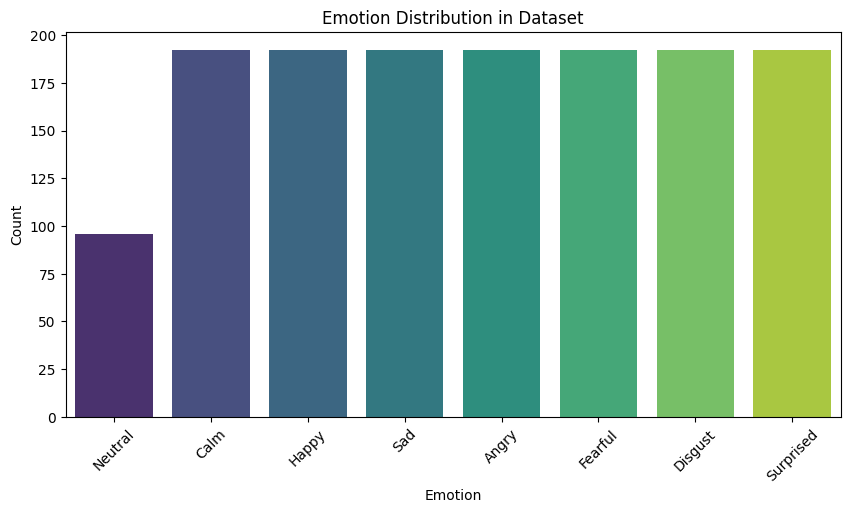

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df["emotion"].map(emotion_labels), order=emotion_labels.values(), palette="viridis")

plt.xlabel("Emotion")
plt.ylabel("Count")
plt.title("Emotion Distribution in Dataset")
plt.xticks(rotation=45)
plt.show()


In [ ]:
display(df)

,file,emotion,intensity,statement,repetition,actor,gender,snr,mfcc_mean,chroma_stft,...,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14
0,03-01-03-01-01-02-09.wav,3,1,1,2,9,Male,6.730347e-06,"[-706.4300537109375, 95.19895935058594, 4.8495...",0.611301,...,11.469189,20.628059,-0.071016,-1.098409,-1.411684,-3.376450,-0.645813,3.638185,-1.383431,-0.284800
1,03-01-07-02-02-02-10.wav,7,2,2,2,10,Female,0.000000e+00,"[-476.0867004394531, 70.18885040283203, -10.70...",0.369353,...,-10.387790,4.679593,-19.215637,-1.456996,-16.618340,-13.975317,-6.438006,0.483184,-8.370224,-10.930006
2,03-01-08-02-02-01-09.wav,8,2,2,1,9,Male,1.035439e-06,"[-751.964599609375, 76.01713562011719, 10.1744...",0.528253,...,8.567366,16.729588,-0.157966,4.658631,-2.602558,0.269521,-0.405713,-2.892875,-3.087559,-0.473730
3,03-01-03-01-02-01-12.wav,3,1,2,1,12,Female,0.000000e+00,"[-621.8660888671875, 65.24585723876953, -11.99...",0.479008,...,-0.519485,7.619534,-13.272074,-0.297851,-10.450953,-12.336401,-5.172411,-3.245183,-8.796328,-0.610236
4,03-01-04-01-01-01-08.wav,4,1,1,1,8,Female,9.836657e-06,"[-752.6741943359375, 71.02371215820312, 17.396...",0.566075,...,9.684851,20.472408,-1.417557,12.607273,-4.493764,1.043121,0.071770,-1.172807,1.800034,-4.045017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,03-01-06-02-02-01-14.wav,6,2,2,1,14,Female,0.000000e+00,"[-521.8727416992188, 33.33415222167969, -26.97...",0.401203,...,-10.838760,-5.483819,-19.880278,-2.062749,-13.693341,-14.032293,-1.549396,-6.734634,-13.192415,-3.512537
1436,03-01-07-01-02-01-04.wav,7,1,2,1,4,Female,-7.765792e-07,"[-607.0526123046875, 47.369075775146484, -5.25...",0.452226,...,-6.792320,3.111269,-12.387634,-1.556534,-10.128782,-9.280766,-5.295249,-3.558451,-4.960642,-4.803607
1437,03-01-06-02-02-01-07.wav,6,2,2,1,7,Male,0.000000e+00,"[-462.95330810546875, 45.73112869262695, -22.4...",0.456878,...,-8.094124,9.149704,-21.062580,-8.943297,-11.324056,-12.091948,-7.007240,-6.466037,-7.653590,-4.470612
1438,03-01-05-01-01-01-19.wav,5,1,1,1,19,Male,2.070877e-06,"[-558.0512084960938, 64.9394760131836, -6.3088...",0.492190,...,3.860692,7.621563,-5.836644,4.296150,-4.843230,-1.659126,-7.207257,-3.603410,4.737973,-1.539337


Data Pre-processing and Normalization

In [ ]:
df_numeric = df.drop(columns=["file", "statement", "repetition", "actor", "gender","mfcc_mean"])

In [ ]:
X = df_numeric.drop(columns=["emotion"]).values
y = df_numeric["emotion"].values

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
display(df_numeric)

,emotion,intensity,snr,chroma_stft,mel_mean,spectral_contrast,tonnetz,spectral_centroid,spectral_rolloff,spectral_bandwidth,...,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14
0,3,1,6.730347e-06,0.611301,0.003910,14.452159,-0.017415,5802.786872,11493.481739,5332.264115,...,11.469189,20.628059,-0.071016,-1.098409,-1.411684,-3.376450,-0.645813,3.638185,-1.383431,-0.284800
1,7,2,0.000000e+00,0.369353,0.290096,18.532038,-0.032357,4553.509059,8541.558397,4677.451194,...,-10.387790,4.679593,-19.215637,-1.456996,-16.618340,-13.975317,-6.438006,0.483184,-8.370224,-10.930006
2,8,2,1.035439e-06,0.528253,0.001570,13.614932,0.000683,5321.343580,10413.061523,4838.077925,...,8.567366,16.729588,-0.157966,4.658631,-2.602558,0.269521,-0.405713,-2.892875,-3.087559,-0.473730
3,3,1,0.000000e+00,0.479008,0.016571,15.773914,-0.010748,5516.399061,10446.357333,4770.430503,...,-0.519485,7.619534,-13.272074,-0.297851,-10.450953,-12.336401,-5.172411,-3.245183,-8.796328,-0.610236
4,4,1,9.836657e-06,0.566075,0.001300,15.029716,-0.005610,5971.529098,13193.532437,6220.346618,...,9.684851,20.472408,-1.417557,12.607273,-4.493764,1.043121,0.071770,-1.172807,1.800034,-4.045017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,6,2,0.000000e+00,0.401203,0.143001,16.576972,0.010604,5776.318155,10396.276596,4326.456915,...,-10.838760,-5.483819,-19.880278,-2.062749,-13.693341,-14.032293,-1.549396,-6.734634,-13.192415,-3.512537
1436,7,1,-7.765792e-07,0.452226,0.031916,15.588811,-0.001773,6316.170505,11457.163665,4938.125861,...,-6.792320,3.111269,-12.387634,-1.556534,-10.128782,-9.280766,-5.295249,-3.558451,-4.960642,-4.803607
1437,6,2,0.000000e+00,0.456878,0.356192,16.576063,-0.010901,5648.765101,11110.839844,4795.267648,...,-8.094124,9.149704,-21.062580,-8.943297,-11.324056,-12.091948,-7.007240,-6.466037,-7.653590,-4.470612
1438,5,1,2.070877e-06,0.492190,0.046170,15.845898,-0.009165,4953.512702,9884.136653,4852.137555,...,3.860692,7.621563,-5.836644,4.296150,-4.843230,-1.659126,-7.207257,-3.603410,4.737973,-1.539337


In [ ]:
print(df_numeric.columns)

Index(['emotion', 'intensity', 'snr', 'chroma_stft', 'mel_mean',
       'spectral_contrast', 'tonnetz', 'spectral_centroid', 'spectral_rolloff',
       'spectral_bandwidth', 'tempo', 'rms', 'zero_crossing_rate', 'mfcc_1',
       'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8',
       'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14'],
      dtype='object')


###Convolutional Neural Network (CNN) + Multilayer Perceptron (MLP)

In [ ]:
mfcc_features = [f'mfcc_{i}' for i in range(1, 14)]
scalar_features = ['chroma_stft', 'mel_mean', 'spectral_contrast', 'tonnetz',
                   'spectral_centroid', 'spectral_rolloff', 'spectral_bandwidth',
                   'tempo', 'rms', 'zero_crossing_rate']

####Labels Encoding

In [ ]:
label_encoder = LabelEncoder()
df_numeric['emotion'] = label_encoder.fit_transform(df_numeric['emotion'])

####Train-Validation-Test Split

In [ ]:
X_mfcc = df_numeric[mfcc_features].values.reshape(df_numeric.shape[0], 1, 13, 1)
X_scalar = df_numeric[scalar_features].values
y = df_numeric['emotion'].values

X_train_mfcc, X_temp_mfcc, X_train_scalar, X_temp_scalar, y_train, y_temp = train_test_split(
    X_mfcc, X_scalar, y, test_size=0.3, random_state=42, stratify=y)

X_val_mfcc, X_test_mfcc, X_val_scalar, X_test_scalar, y_val, y_test = train_test_split(
    X_temp_mfcc, X_temp_scalar, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

####Custom PyTorch Dataset

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, mfcc_data, scalar_data, labels):
        self.mfcc_data = torch.tensor(mfcc_data, dtype=torch.float32)
        self.scalar_data = torch.tensor(scalar_data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.mfcc_data[idx], self.scalar_data[idx], self.labels[idx]

####DataLoader

In [ ]:
batch_size = 32
train_dataset = EmotionDataset(X_train_mfcc, X_train_scalar, y_train)
val_dataset = EmotionDataset(X_val_mfcc, X_val_scalar, y_val)
test_dataset = EmotionDataset(X_test_mfcc, X_test_scalar, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

####Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

####Model Architecture

In [ ]:
class CNN_MLP_Model(nn.Module):
    def __init__(self, scalar_input_dim, num_classes):
        super(CNN_MLP_Model, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 1), stride=1, padding=(1, 0)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),

            nn.Conv2d(64, 128, kernel_size=(3, 1), stride=1, padding=(1, 0)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten()

        )

        cnn_output_dim = 128 * 6 * 1
        self.mlp = nn.Sequential(
            nn.Linear(scalar_input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Final Classifier
        self.fc = nn.Sequential(
            nn.Linear(cnn_output_dim + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, mfcc_input, scalar_input):
        cnn_out = self.cnn(mfcc_input)  # CNN Output
        mlp_out = self.mlp(scalar_input)  # MLP Output
        combined = torch.cat((cnn_out, mlp_out), dim=1)  # Fusion
        output = self.fc(combined)
        return output

In [ ]:
num_classes = len(df_numeric['emotion'].unique())
model = CNN_MLP_Model(scalar_input_dim=len(scalar_features), num_classes=num_classes).to(device)


####Loss and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

####Model Train

In [ ]:
def train_model(model, train_loader, test_loader, num_epochs=20):
    train_losses, test_losses, train_accs, test_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss, correct_train, total_train = 0, 0, 0

        for mfcc_batch, scalar_batch, labels in train_loader:
            mfcc_batch, scalar_batch, labels = mfcc_batch.to(device), scalar_batch.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(mfcc_batch, scalar_batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_acc = correct_train / total_train
        train_losses.append(total_train_loss / len(train_loader))
        train_accs.append(train_acc)

        # Validation Phase
        model.eval()
        total_test_loss, correct_test, total_test = 0, 0, 0

        with torch.no_grad():
            for mfcc_batch, scalar_batch, labels in test_loader:
                mfcc_batch, scalar_batch, labels = mfcc_batch.to(device), scalar_batch.to(device), labels.to(device)

                outputs = model(mfcc_batch, scalar_batch)
                loss = criterion(outputs, labels)

                total_test_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)

        test_acc = correct_test / total_test
        test_losses.append(total_test_loss / len(test_loader))
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_acc:.4f}")

    return train_losses, test_losses, train_accs, test_accs

In [ ]:
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, num_epochs=50)

Epoch 1/50, Train Loss: 2.0615, Train Acc: 0.1498, Test Loss: 2.0411, Test Acc: 0.2500
Epoch 2/50, Train Loss: 1.9687, Train Acc: 0.2153, Test Loss: 1.9328, Test Acc: 0.2407
Epoch 3/50, Train Loss: 1.8651, Train Acc: 0.2470, Test Loss: 1.8448, Test Acc: 0.2778
Epoch 4/50, Train Loss: 1.8105, Train Acc: 0.2768, Test Loss: 1.8512, Test Acc: 0.2685
Epoch 5/50, Train Loss: 1.7792, Train Acc: 0.2877, Test Loss: 1.7626, Test Acc: 0.2639
Epoch 6/50, Train Loss: 1.7847, Train Acc: 0.2857, Test Loss: 1.7818, Test Acc: 0.2963
Epoch 7/50, Train Loss: 1.7650, Train Acc: 0.2788, Test Loss: 1.7427, Test Acc: 0.2870
Epoch 8/50, Train Loss: 1.7355, Train Acc: 0.3026, Test Loss: 1.7613, Test Acc: 0.3056
Epoch 9/50, Train Loss: 1.7488, Train Acc: 0.3125, Test Loss: 1.7295, Test Acc: 0.3009
Epoch 10/50, Train Loss: 1.7056, Train Acc: 0.3274, Test Loss: 1.6923, Test Acc: 0.3102
Epoch 11/50, Train Loss: 1.7000, Train Acc: 0.3274, Test Loss: 1.7216, Test Acc: 0.3009
Epoch 12/50, Train Loss: 1.6907, Train Ac

####Plots

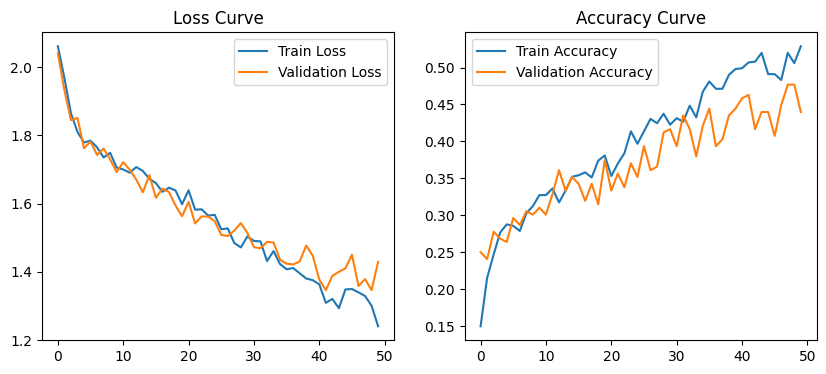

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Curve")

plt.show()

####Model Evaluation

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for mfcc_input, scalar_input, labels in test_loader:
            mfcc_input = mfcc_input.to(device)
            scalar_input = scalar_input.to(device)
            labels = labels.to(device)

            outputs = model(mfcc_input, scalar_input)
            predictions = torch.argmax(outputs, dim=1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


Test Accuracy: 46.30%

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.45      0.79      0.57        28
           2       0.42      0.28      0.33        29
           3       0.36      0.28      0.31        29
           4       0.53      0.69      0.60        29
           5       0.56      0.31      0.40        29
           6       0.40      0.55      0.46        29
           7       0.53      0.59      0.56        29

    accuracy                           0.46       216
   macro avg       0.41      0.43      0.40       216
weighted avg       0.43      0.46      0.43       216



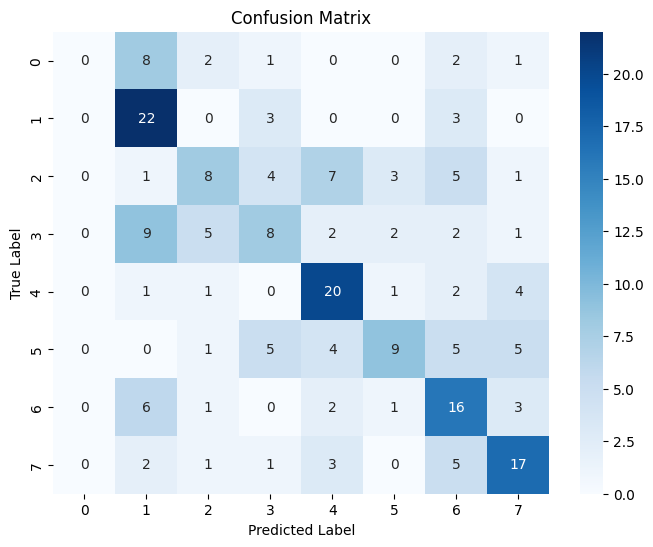

In [ ]:
evaluate_model(model, test_loader, device)